In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
# from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Nhóm 3/Bài tập trên lớp/Báo cáo tiến trình/Project/feature_extraction.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   xeploai_tt            35849 non-null  int64  
 2   hocky                 35849 non-null  int64  
 3   namhoc                35849 non-null  int64  
 4   drltl                 35849 non-null  int64  
 5   sotchk                35849 non-null  int64  
 6   dtbhk_truoc           35849 non-null  float64
 7   xeploai               35849 non-null  int64  
 8   khuvuc_encoded        35849 non-null  int64  
 9   namnhaphoc            35849 non-null  int64  
 10  chuyennganh2_encoded  35849 non-null  float64
 11  hedt_encoded          35849 non-null  int64  
 12  khoa_encoded          35849 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 3.6 MB


# Sau khi Combine

In [9]:
def build_initial_graph(W, feature_names):
    G = nx.Graph()
    num_features = len(feature_names)
    for i, name in enumerate(feature_names):
        G.add_node(i, label=name)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            if W[i, j] > 0:
                G.add_edge(i, j, weight=W[i, j])
    return G


def average_pooling_layer(data, clusters):
    pooled_data = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_data = data.iloc[:, cluster]
        pooled_data[f"Cluster_{i+1}"] = cluster_data.mean(axis=1)
    return pooled_data


def cluster_graph(G, num_clusters):
    adj_matrix = nx.to_numpy_array(G)

    clustering = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='average'
    )
    cluster_labels = clustering.fit_predict(1 - adj_matrix)
    clusters = [[] for _ in range(num_clusters)]
    for node, label in enumerate(cluster_labels):
        clusters[label].append(node)
    return clusters


def hierarchical_clustering_with_pooling(data, W, feature_names, num_layers, num_clusters):
    pooled_layers = [data]
    graphs = []

    G = build_initial_graph(W, feature_names)
    graphs.append(G)

    for layer in range(num_layers):
        print(f"Building Layer {layer + 1}...")
        clusters = cluster_graph(G, num_clusters)
        pooled_data = average_pooling_layer(pooled_layers[-1], clusters)
        pooled_layers.append(pooled_data)
        G = build_initial_graph(
            np.corrcoef(pooled_data.T, rowvar=True), pooled_data.columns
        )
        graphs.append(G)

    return pooled_layers, graphs


def visualize_graph(G, title="Feature Network"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=700, font_size=10, font_color='white', font_weight='bold'
    )
    edge_colors = [d['weight'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()

In [10]:
df = df[['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc', 'xeploai']]
feature_names = df.columns.drop('xeploai').tolist()

In [11]:
scaler = StandardScaler()
standardized_features = pd.DataFrame(
        scaler.fit_transform(df[feature_names]), columns=feature_names
    )

In [12]:
correlation_matrix = np.corrcoef(standardized_features.T)
np.fill_diagonal(correlation_matrix, 0)   #loại bỏ giá trị tương quan với chính nó
num_layers = 3
num_clusters = 3
pooled_layers, graphs = hierarchical_clustering_with_pooling(
  standardized_features, correlation_matrix, feature_names, num_layers, num_clusters
)

Building Layer 1...
Building Layer 2...
Building Layer 3...


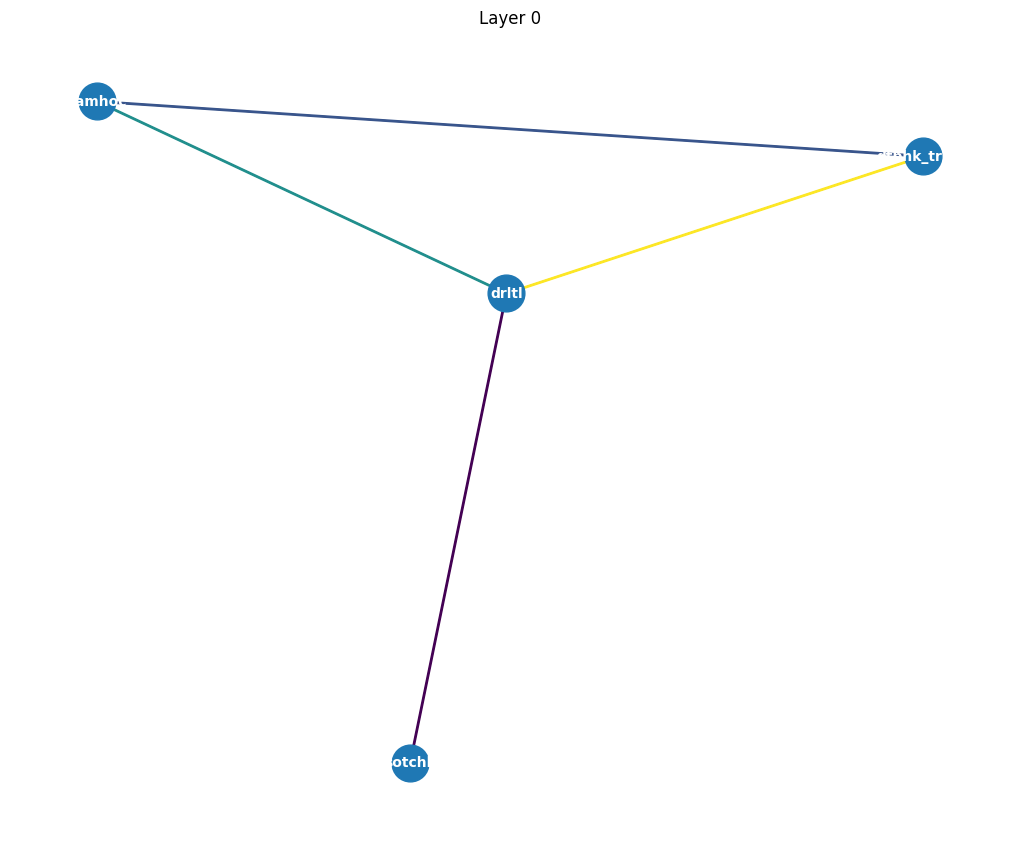

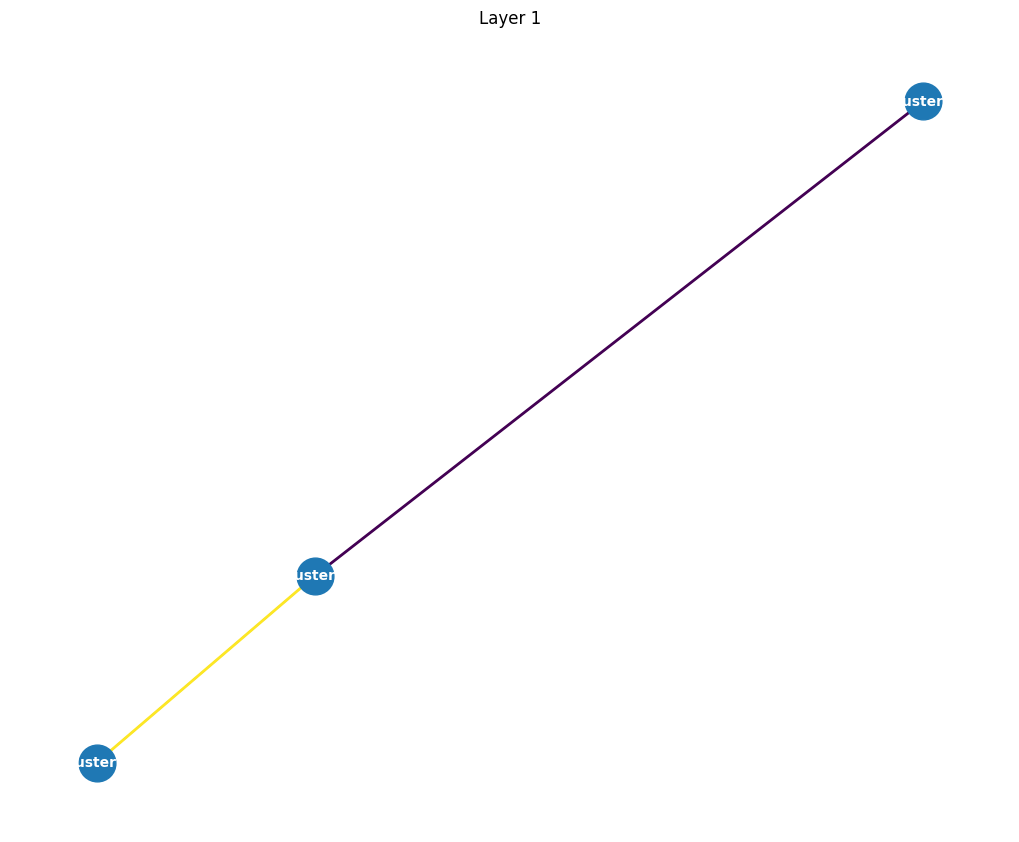

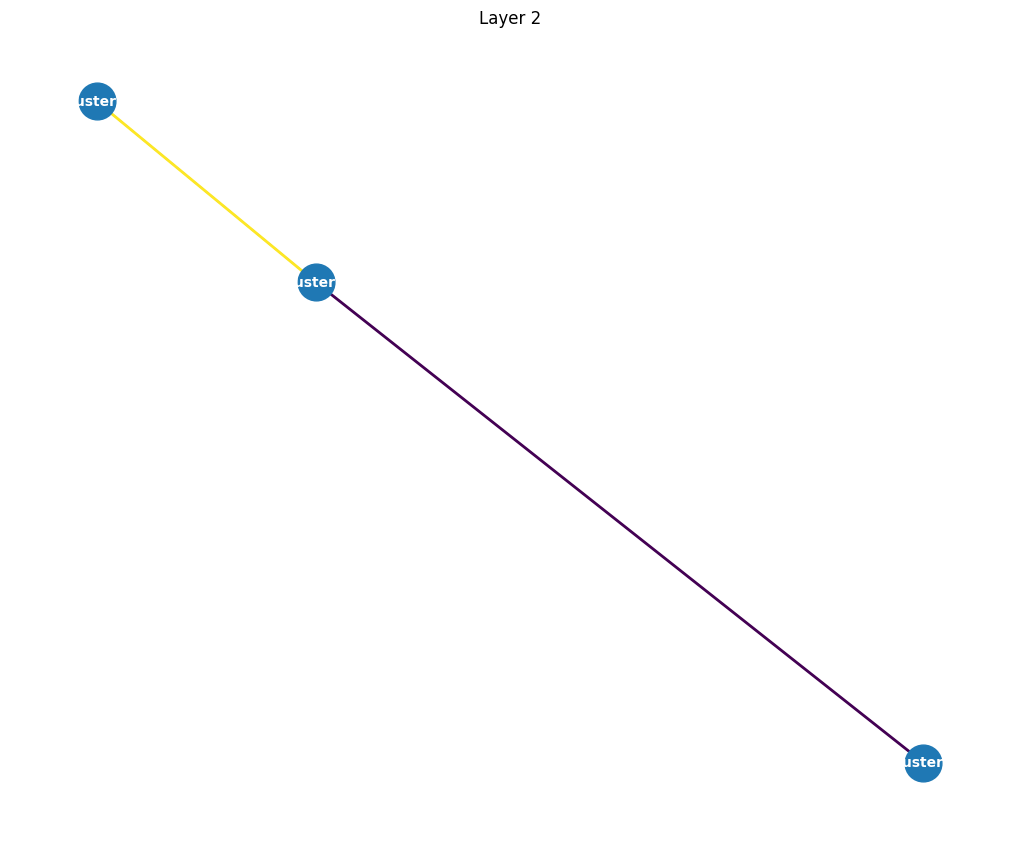

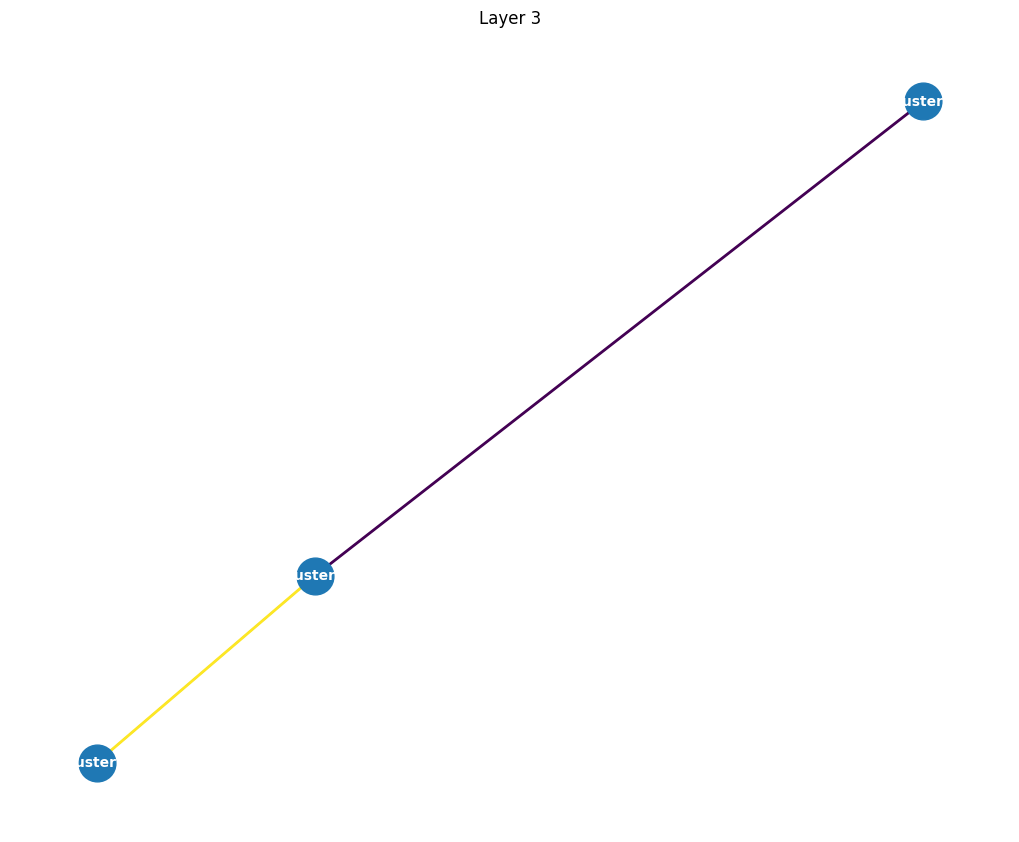

In [13]:
#Visualize
for i, G in enumerate(graphs):
        visualize_graph(G, title=f"Layer {i}")

In [14]:
#Dữ liếu sau pooling
for i, pooled_data in enumerate(pooled_layers):
  print(f"Pooled Data for Layer {i}:")
  print(pooled_data.head())

Pooled Data for Layer 0:
   dtbhk_truoc     drltl    sotchk    namhoc
0     1.065896  0.998521  0.747090  0.181935
1     1.157895  0.998521 -0.563109  0.609536
2     1.221144  0.998521  0.310357  0.609536
3     1.014147  0.998521  0.528724  1.037136
4     0.893398  0.998521  0.528724  1.037136
Pooled Data for Layer 1:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136
Pooled Data for Layer 2:
   Cluster_1  Cluster_2  Cluster_3
0   0.181935   0.747090   1.032209
1   0.609536  -0.563109   1.078208
2   0.609536   0.310357   1.109833
3   1.037136   0.528724   1.006334
4   1.037136   0.528724   0.945960
Pooled Data for Layer 3:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136


In [15]:
X_pooled = pooled_layers[-1]  #lấy layer cuối
y = df['xeploai']

In [16]:
print("Original X shape:", X_pooled.shape)
print("Original y shape:", y.shape)

Original X shape: (35849, 3)
Original y shape: (35849,)


In [17]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X_pooled, y)

In [18]:
print("Sampling X shape:", X.shape)
print("Sampling y shape:", y.shape)

Sampling X shape: (24496, 3)
Sampling y shape: (24496,)


In [19]:
!pip uninstall -y cupy-cuda11x
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu11 cuml-cu11
!pip install pandas==1.5.3

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 841.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.8/502.8 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 906.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.3/839.3 MB 718.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 105.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu11 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.10.1 requires cuda-python<13.0a0,>=12.0, but you have cuda-python 11.8.5.post1 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu11 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-expr 1.1.14 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompati

In [20]:
from cuml.svm import SVC
from cuml.model_selection import GridSearchCV
svm_parameters = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svm = SVC()

grid = GridSearchCV(estimator=svm, param_grid=svm_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X, y)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Score: 0.8566701242652602
Best Parameters: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


In [42]:
from sklearn.model_selection import  cross_val_score
from sklearn.svm import SVC
svm = SVC(C=1000, gamma=1, kernel='rbf', random_state=42)
scores = cross_val_score(svm, X, y, cv=5)
acc_svm_mean = np.mean(scores)
acc_svm_std = np.std(scores)
print(f"Mean Accuracy: {acc_svm_mean:.4f}")
print(f"Standard Deviation: {acc_svm_std:.4f}")

Mean Accuracy: 0.9403
Standard Deviation: 0.0037


Kiểm tra thử có bị overfitting không

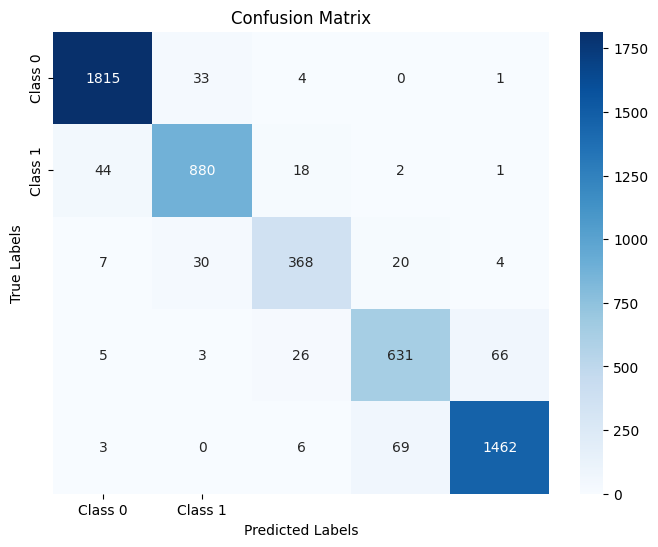

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
unique_classes = np.unique(y_test)
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      1853
     Class 1       0.93      0.93      0.93       945
     Class 2       0.87      0.86      0.86       429
     Class 3       0.87      0.86      0.87       731
     Class 4       0.95      0.95      0.95      1540

    accuracy                           0.94      5498
   macro avg       0.92      0.92      0.92      5498
weighted avg       0.94      0.94      0.94      5498



# Trước khi combine

In [45]:
X = df.drop(['xeploai'], axis =1)
y = df['xeploai']

In [46]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)

In [47]:
print("Resampled X shape:", X.shape)
print("Resampled y shape:", y.shape)

Resampled X shape: (27486, 4)
Resampled y shape: (27486,)


In [48]:
scores = cross_val_score(svm, X, y, cv=10)
acc_svm_mean = np.mean(scores)
acc_svm_std = np.std(scores)
print(f"Mean Accuracy: {acc_svm_mean:.4f}")
print(f"Standard Deviation: {acc_svm_std:.4f}")

Mean Accuracy: 0.9429
Standard Deviation: 0.0046


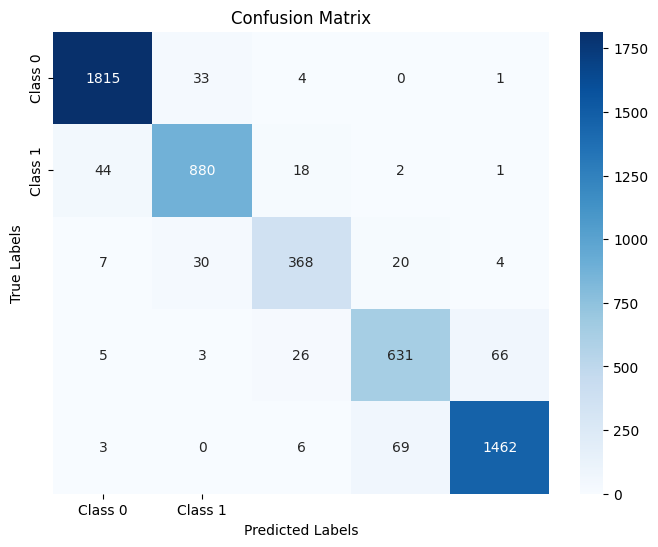

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [50]:
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      1853
     Class 1       0.93      0.93      0.93       945
     Class 2       0.87      0.86      0.86       429
     Class 3       0.87      0.86      0.87       731
     Class 4       0.95      0.95      0.95      1540

    accuracy                           0.94      5498
   macro avg       0.92      0.92      0.92      5498
weighted avg       0.94      0.94      0.94      5498



# So sánh với không trích chọn đặc trưng bằng Filter method

In [51]:
df = pd.read_csv('/content/drive/MyDrive/Nhóm 3/Bài tập trên lớp/Báo cáo tiến trình/Project/feature_extraction.csv')

In [52]:
X = df.drop(['xeploai'], axis =1)
y = df['xeploai']

In [53]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)

In [54]:
scores = cross_val_score(svm, X, y, cv=10)
acc_svm_mean = np.mean(scores)
acc_svm_std = np.std(scores)
print(f"Mean Accuracy: {acc_svm_mean:.4f}")
print(f"Standard Deviation: {acc_svm_std:.4f}")

Mean Accuracy: 0.9029
Standard Deviation: 0.0102


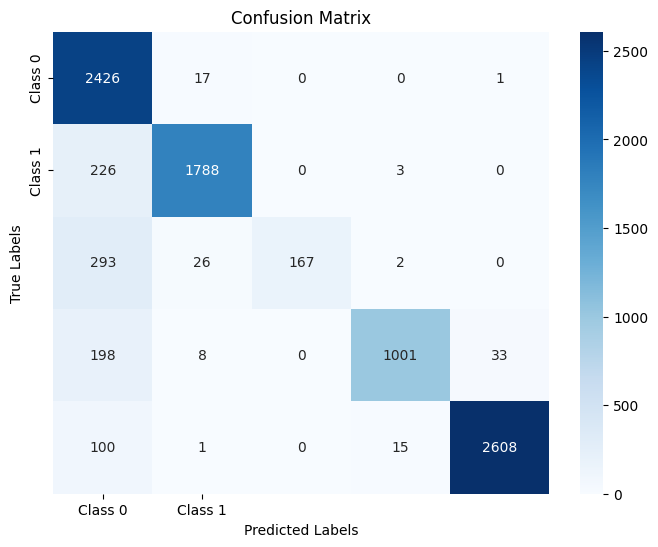

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [56]:
report = classification_report(y_test, y_pred, target_names=[f"Class {cls}" for cls in unique_classes])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.75      0.99      0.85      2444
     Class 1       0.97      0.89      0.93      2017
     Class 2       1.00      0.34      0.51       488
     Class 3       0.98      0.81      0.89      1240
     Class 4       0.99      0.96      0.97      2724

    accuracy                           0.90      8913
   macro avg       0.94      0.80      0.83      8913
weighted avg       0.92      0.90      0.89      8913

